In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import sys

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#keras
import keras
import tensorflow as tf
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

#from hyperas import optim
#from hyperas.distributions import choice, uniform
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import time
LOG_DIR = f"{int(time.time())}"

In [2]:
print('For Codec Augmentation which bitrate you want to use ? Choose from 8,16,32,48,64 and 128')
bitrate = input()

For Codec Augmentation which bitrate you want to use ? Choose from 8,16,32,48,64 and 128
16


In [3]:
#
def feature_dataframe_gen_train(feature_dir):
    feature_dataframe = []
    for sess in range(1,5) :
        feature_df = pd.read_csv('{}audio_features_{}.csv'.format(feature_dir,sess))
        feature_df = feature_df.sample(frac=1,random_state = 50).reset_index(drop = True)
        feature_dataframe.append(feature_df)
    feature_dataframe = (pd.concat(feature_dataframe)).fillna(0)
    feature_dataframe = feature_dataframe.replace('exc','hap')
    #feature_dataframe = feature_dataframe.drop(feature_dataframe[feature_dataframe.emotions.isin(["sur", "fea"])].index)
    return feature_dataframe

def feature_dataframe_codec_train(feature_dir):
    feature_dataframe = []
    for sess in range(1,5) :
        feature_df = pd.read_csv('{}audio_features_{}_{}.csv'.format(feature_dir,bitrate,sess))
        feature_df = feature_df.sample(frac=1,random_state = 50).reset_index(drop = True)
        feature_dataframe.append(feature_df)
    feature_dataframe = (pd.concat(feature_dataframe)).fillna(0)
    feature_dataframe = feature_dataframe.replace('exc','hap')
    #feature_dataframe = feature_dataframe.drop(feature_dataframe[feature_dataframe.emotions.isin(["sur", "fea"])].index)
    return feature_dataframe

def feature_dataframe_gen_test(feature_dir):
    feature_dataframe = []
    for sess in [5] :
        feature_df = pd.read_csv('{}audio_features_{}.csv'.format(feature_dir,sess))
        feature_df = feature_df.sample(frac=1,random_state = 50).reset_index(drop = True)
        feature_dataframe.append(feature_df)
    feature_dataframe = (pd.concat(feature_dataframe)).fillna(0)
    feature_dataframe = feature_dataframe.replace('exc','hap')
    #feature_dataframe = feature_dataframe.drop(feature_dataframe[feature_dataframe.emotions.isin(["sur", "fea"])].index)
    return feature_dataframe

In [4]:
#CodecAugment - 8,16,32,48,64,128 kbps
ori_feature_dataframe_train = feature_dataframe_gen_train(feature_dir = '../input/iemocap-audio-features/')
ori_feature_dataframe_train['fold'] = -1
codec_feature_dataframe_train = feature_dataframe_codec_train(feature_dir = '../input/iemocap-compressed/')
codec_feature_dataframe_train['fold'] = -1
ori_feature_dataframe_test = feature_dataframe_gen_test(feature_dir = '../input/iemocap-audio-features/')
ori_feature_dataframe_test['fold'] = 1
result = (pd.concat([ori_feature_dataframe_train, codec_feature_dataframe_train,ori_feature_dataframe_test], ignore_index=True, sort=False)).fillna(0.0)
result = result.loc[:, (result==0.0).mean() < .9]
training_data = result[result['fold'] == -1]
testing_data = result[result['fold'] == 1]
X_train_data = training_data.drop(['emotions', 'fold'],axis=1)
X_test_data = testing_data.drop(['emotions', 'fold'],axis=1)
y_train_data = training_data.emotions
y_test_data = testing_data.emotions
scaler = StandardScaler()
std_scale = scaler.fit(X_train_data)
X_train = std_scale.transform(X_train_data)
X_test  = std_scale.transform(X_test_data)
y_train_ = np.array(y_train_data)
y_test_ = np.array(y_test_data)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train_))
y_test = np_utils.to_categorical(lb.fit_transform(y_test_))
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

In [5]:
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(1241, 2981, 1)
(1241, 4)
(8580, 2981, 1)
(8580, 4)


# Play with keras tuner

In [6]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(Conv1D(filters = hp.Int('filters_1', min_value = 32, max_value = 512, step = 32, default = 256),
                     kernel_size = hp.Int('kernel_size_1',min_value = 2, max_value = 10, step = 2, default = 8),
                     padding = 'same', input_shape=(X_train.shape[1],1)))
    model.add(Activation('relu'))
    model.add(Conv1D(filters = hp.Int('filters_2', min_value = 32, max_value = 512, step = 32, default = 256),
                     kernel_size = hp.Int('kernel_size_2',min_value = 2, max_value = 10, step = 2, default = 8),
                     padding = 'same'))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(rate=hp.Float("dropout_1", min_value=0.0, max_value=0.5, default=0.05, step=0.05)))
    model.add(MaxPooling1D(pool_size=(8)))
    for i in range(hp.Int('n_layers', 1, 5)):
        model.add(Conv1D(filters = hp.Int(f'filters_3_{i}', min_value = 32, max_value = 512, step = 32, default = 256),
                         kernel_size = hp.Int(f'kernel_size_3_{i}',min_value = 2, max_value = 10, step = 2, default = 8),padding = 'same'))
        model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Dropout(rate=hp.Float("dropout_2", min_value=0.0, max_value=0.5, default=0.05, step=0.05)))
    model.add(MaxPooling1D(pool_size=(8)))
    for i in range(hp.Int('n_layers', 1, 5)):
        model.add(Conv1D(filters = hp.Int(f'filters_4_{i}', min_value = 32, max_value = 512, step = 32, default = 256),
                        kernel_size = hp.Int(f'kernel_size_4_{i}',min_value = 2, max_value = 10, step = 2, default = 8),padding = 'same'))
        model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(4, activation="softmax"))
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    hp_momentum = hp.Choice('momentum', values = [0.0,0.25,0.5, 0.7, 0.9, 0.99])
    opt = keras.optimizers.SGD(learning_rate = hp_learning_rate,momentum = hp_momentum,nesterov=False,decay = 0.0)
    opt1 = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    opt2 = keras.optimizers.RMSprop(learning_rate=hp_learning_rate,decay = 1e-6)
    model.compile(optimizer = opt,
                 loss = keras.losses.CategoricalCrossentropy(),
                 metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy'])
    
    return model

In [7]:
LOG_DIR = f"{int(time.time())}"
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=7,
    executions_per_trial=1,
    directory='LOG_DIR',
    project_name='iemocap')

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 13
filters_1 (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size_1 (Int)
{'default': 8, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': None}
filters_2 (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size_2 (Int)
{'default': 8, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': None}
dropout_1 (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
filters_3_0 (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size_3_0 (Int)
{'default': 8, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': None}
dropout_2 (Float)


In [9]:
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=16,
             validation_data=(X_test, y_test))

Trial 7 Complete [00h 17m 07s]
val_accuracy: 0.44238516688346863

Best val_accuracy So Far: 0.5012087225914001
Total elapsed time: 02h 28m 12s


In [10]:
models = tuner.get_best_models(num_models=2)

In [11]:
a = [model.summary() for model in models] 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2981, 480)         3360      
_________________________________________________________________
activation (Activation)      (None, 2981, 480)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2981, 224)         215264    
_________________________________________________________________
batch_normalization (BatchNo (None, 2981, 224)         896       
_________________________________________________________________
activation_1 (Activation)    (None, 2981, 224)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2981, 224)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 372, 224)          0

In [12]:
tuner.results_summary()

Results summary
Results in LOG_DIR/iemocap
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters_1: 480
kernel_size_1: 6
filters_2: 224
kernel_size_2: 2
dropout_1: 0.0
n_layers: 3
filters_3_0: 448
kernel_size_3_0: 6
dropout_2: 0.1
filters_4_0: 384
kernel_size_4_0: 2
learning_rate: 0.0001
momentum: 0.5
filters_3_1: 480
kernel_size_3_1: 8
filters_3_2: 192
kernel_size_3_2: 6
filters_4_1: 384
kernel_size_4_1: 4
filters_4_2: 64
kernel_size_4_2: 8
filters_3_3: 320
kernel_size_3_3: 6
filters_4_3: 160
kernel_size_4_3: 6
Score: 0.5012087225914001
Trial summary
Hyperparameters:
filters_1: 352
kernel_size_1: 8
filters_2: 192
kernel_size_2: 8
dropout_1: 0.15000000000000002
n_layers: 2
filters_3_0: 352
kernel_size_3_0: 4
dropout_2: 0.30000000000000004
filters_4_0: 224
kernel_size_4_0: 2
learning_rate: 0.0001
momentum: 0.25
filters_3_1: 224
kernel_size_3_1: 4
filters_3_2: 448
kernel_size_3_2: 4
filters_4_1: 384
kernel_size_4_1: 6
filters_4_2: 4

In [13]:
models = tuner.get_best_models(num_models=2)

In [14]:
model_name = 'Emotion_recognition_iemocap_specAugment.h5'
save_dir = os.path.join(os.getcwd(),'saved_models')
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
model_path = os.path.join(save_dir,model_name)


models[1].save(model_path)
print("save model and weight at %s" %model_path)
#save model to disk
model_json = models[1].to_json()
with open("model_json.json", "w") as file:
    file.write(model_json)

save model and weight at /kaggle/working/saved_models/Emotion_recognition_iemocap_specAugment.h5


In [15]:
# loading json and model architecture 
json_file = open('./model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./saved_models/Emotion_recognition_iemocap_specAugment.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

preds = loaded_model.predict(X_test, batch_size=16, verbose=1)

preds=preds.argmax(axis=1)

print(preds)

Loaded model from disk
recall_1: 18.69%
78/78 [==============================] - 1s 15ms/step
[0 2 2 ... 2 2 3]


In [16]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)

# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
print(finaldf.groupby('predictedvalues').count())

                 actualvalues
predictedvalues              
ang                       146
hap                       303
neu                       640
sad                       152


In [17]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.5012087026591459


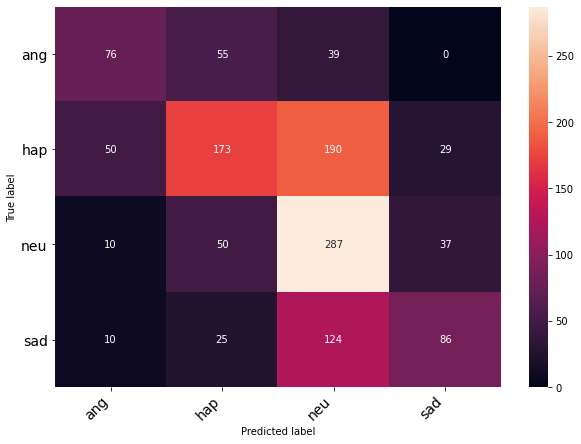

In [18]:
finaldf = pd.read_csv("./Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
plt.show(print_confusion_matrix(c, class_names = classes))


In [19]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

         ang       0.52      0.45      0.48       170
         hap       0.57      0.39      0.46       442
         neu       0.45      0.75      0.56       384
         sad       0.57      0.35      0.43       245

    accuracy                           0.50      1241
   macro avg       0.53      0.48      0.48      1241
weighted avg       0.53      0.50      0.49      1241

